In [4]:
import os
import numpy as np
import tensorflow as tf
#import data as d
#import model
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
import matplotlib.pyplot as plt

In [2]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [5]:

rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state


class Attention_Layer():
    """
    어텐션 레이어.
    (None, TimeWindow, hidden_unit_size) shape의 LSTM 출력을 입력으로 받아 (None, 1, hidden_unit_size)의 텐서 출력.
    
    """
    def __init__(
        self,
        timewindow_size,
        input_hidden_unit_size,
        attention_size=None):
        """
        Setting parameter for attention layer.
        args:
            timewindow_size = time window size of previous lstm layer.
            input_hidden_unit_size = hidden unit number of previous lstm layer.
            attention_size = size of this attention. 
                default = input_hidden_unit_size.
        """
        if(attention_size is None):
            attention_size=input_hidden_unit_size
        self.o_size=attention_size
        self.h_size=input_hidden_unit_size
        self.t_size=timewindow_size

        self.beta_weight=tf.Variable(tf.random.normal([self.h_size,self.o_size]), name='beta_weight')
        self.beta_bias=tf.Variable(tf.zeros([self.o_size]),name='beta_bias')

        self.v=tf.Variable(tf.random.normal([self.o_size,1]),name='beta_v')

    def __call__(self,inputs):
        """
        producing output with actual inputs.
        shape of output will be (batch_size, 1, input_hidden_unit_size).
        """
        #temp = tanh(Y X W + b) ->shape of result = (-1, self.o_size)
        temp=tf.matmul(tf.reshape(inputs,[-1,self.h_size]),self.beta_weight)
         
        temp=tf.tanh(temp+self.beta_bias)
        
            
        #j=temp X v
        j=tf.reshape(tf.matmul(temp,self.v),[-1,self.t_size,1])

        beta=tf.nn.softmax(j)
        
        

        output=beta*inputs
        return output



In [6]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
       

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
       
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
       

        #Attention_Layer
        attention_layer=Attention_Layer(self.T,64)
        
        Y_3=attention_layer(Y_2)
        

        #Non-linear units for producing final prediction.
        R_1=tf.compat.v1.layers.dense(tf.compat.v1.layers.flatten(Y_3),64,tf.nn.relu)
        
        R_2=tf.compat.v1.layers.dense(R_1,64,tf.nn.relu)
        
        R_3=tf.compat.v1.layers.dense(R_2,64,tf.nn.relu)
        
        R_4=tf.compat.v1.layers.dense(R_3,64,tf.nn.relu)
        
        R_5=tf.compat.v1.layers.dense(R_4,64,tf.nn.relu)
        
        R_6=tf.compat.v1.layers.dense(R_5,1)
       
        self.out=R_6
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)

    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

## batch_size=512 & timesize_for_calc_correlation=50
## time_size=16 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10 &epoch=500

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1)

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  3.050675628706813
evalution_cost :  1.3841217532753944
epoch : 17, t_cost : 0.028247, e_cost : 0.030090, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  3.0258865859359503
evalution_cost :  1.3874722383916378
epoch : 18, t_cost : 0.028017, e_cost : 0.030162, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.998129228129983
evalution_cost :  1.3882416933774948
epoch : 19, t_cost : 0.027760, e_cost : 0.030179, elapsed time : 26.79sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.8011632151901722
evalution_cost :  1.7440606877207756
epoch : 43, t_cost : 0.016677, e_cost : 0.037914, elapsed time : 26.59sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.7440703734755516
evalution_cost :  1.9000265412032604
epoch : 44, t_cost : 0.016149, e_cost : 0.041305, elapsed time : 26.67sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.6951191974803805
evalution_cost :  1.9275798462331295
epoch : 45, t_cost : 0.015696, e_cost : 0.041904, elapsed time : 26.74sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.5596363848308101
evalution_cost :  2.2730528879910707
epoch : 69, t_cost : 0.005182, e_cost : 0.049414, elapsed time : 26.59sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.57924201968126
evalution_cost :  2.1762335002422333
epoch : 70, t_cost : 0.005363, e_cost : 0.047309, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.6011322347912937
evalution_cost :  2.18409869633615
epoch : 71, t_cost : 0.005566, e_cost : 0.047480, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3255576951196417
evalution_cost :  2.140250062569976
epoch : 95, t_cost : 0.003014, e_cost : 0.046527, elapsed time : 26.22sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3013368915999308
evalution_cost :  2.0859754979610443
epoch : 96, t_cost : 0.002790, e_cost : 0.045347, elapsed time : 26.37sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.32711190287955105
evalution_cost :  2.105260780081153
epoch : 97, t_cost : 0.003029, e_cost : 0.045767, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10,

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.24883797334041446
evalution_cost :  2.013072356581688
epoch : 121, t_cost : 0.002304, e_cost : 0.043762, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.24879907188005745
evalution_cost :  2.0231453347951174
epoch : 122, t_cost : 0.002304, e_cost : 0.043981, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.33803854387952015
evalution_cost :  2.033696111291647
epoch : 123, t_cost : 0.003130, e_cost : 0.044211, elapsed time : 26.37sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.215500011225231
evalution_cost :  1.9484476540237665
epoch : 147, t_cost : 0.001995, e_cost : 0.042358, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.20958631770918146
evalution_cost :  1.9666932728141546
epoch : 148, t_cost : 0.001941, e_cost : 0.042754, elapsed time : 26.49sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.21183869009837508
evalution_cost :  1.9939842596650124
epoch : 149, t_cost : 0.001961, e_cost : 0.043347, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.19114215741865337
evalution_cost :  1.9601091407239437
epoch : 173, t_cost : 0.001770, e_cost : 0.042611, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.19551979398238473
evalution_cost :  1.9306431356817484
epoch : 174, t_cost : 0.001810, e_cost : 0.041971, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.2109597879461944
evalution_cost :  1.9920109324157238
epoch : 175, t_cost : 0.001953, e_cost : 0.043305, elapsed time : 26.81sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.16361180070089176
evalution_cost :  1.9437970500439405
epoch : 199, t_cost : 0.001515, e_cost : 0.042256, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.16500692535191774
evalution_cost :  1.9337062165141106
epoch : 200, t_cost : 0.001528, e_cost : 0.042037, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.16260945331305265
evalution_cost :  1.9319027978926897
epoch : 201, t_cost : 0.001506, e_cost : 0.041998, elapsed time : 26.59sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.18551978009054437
evalution_cost :  1.9040895253419876
epoch : 225, t_cost : 0.001718, e_cost : 0.041393, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1687541663995944
evalution_cost :  1.9019964002072811
epoch : 226, t_cost : 0.001563, e_cost : 0.041348, elapsed time : 26.59sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1502644972933922
evalution_cost :  1.899519318714738
epoch : 227, t_cost : 0.001391, e_cost : 0.041294, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895,

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.091582297522109
evalution_cost :  1.8889530077576637
epoch : 251, t_cost : 0.000848, e_cost : 0.041064, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09033203896251507
evalution_cost :  1.877850303426385
epoch : 252, t_cost : 0.000836, e_cost : 0.040823, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09223855432355776
evalution_cost :  1.8728866903111339
epoch : 253, t_cost : 0.000854, e_cost : 0.040715, elapsed time : 26.70sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895,

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.11752223144867457
evalution_cost :  1.880100886337459
epoch : 277, t_cost : 0.001088, e_cost : 0.040872, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.11156182253034785
evalution_cost :  1.8667306089773774
epoch : 278, t_cost : 0.001033, e_cost : 0.040581, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.13483617067686282
evalution_cost :  1.8912618439644575
epoch : 279, t_cost : 0.001248, e_cost : 0.041114, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.11958427572972141
evalution_cost :  1.934696115553379
epoch : 303, t_cost : 0.001107, e_cost : 0.042059, elapsed time : 26.54sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.13621576948207803
evalution_cost :  2.0093598924577236
epoch : 304, t_cost : 0.001261, e_cost : 0.043682, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.15592347702477127
evalution_cost :  1.921450449153781
epoch : 305, t_cost : 0.001444, e_cost : 0.041771, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08149740827502683
evalution_cost :  1.9645876372233033
epoch : 329, t_cost : 0.000755, e_cost : 0.042708, elapsed time : 26.33sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08504311759315897
evalution_cost :  1.9583406932651997
epoch : 330, t_cost : 0.000787, e_cost : 0.042573, elapsed time : 26.25sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09974403685191646
evalution_cost :  1.971665345132351
epoch : 331, t_cost : 0.000924, e_cost : 0.042862, elapsed time : 26.34sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0741066435148241
evalution_cost :  1.8373860493302345
epoch : 355, t_cost : 0.000686, e_cost : 0.039943, elapsed time : 26.62sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07857556674571242
evalution_cost :  1.852476168423891
epoch : 356, t_cost : 0.000728, e_cost : 0.040271, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07977894143550657
evalution_cost :  1.8711413107812405
epoch : 357, t_cost : 0.000739, e_cost : 0.040677, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07409557086066343
evalution_cost :  1.9030061904340982
epoch : 381, t_cost : 0.000686, e_cost : 0.041370, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07562157321081031
evalution_cost :  1.9236261751502752
epoch : 382, t_cost : 0.000700, e_cost : 0.041818, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08950169690069743
evalution_cost :  1.8902805671095848
epoch : 383, t_cost : 0.000829, e_cost : 0.041093, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07100504387926776
evalution_cost :  1.8524314910173416
epoch : 407, t_cost : 0.000657, e_cost : 0.040270, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07519106692052446
evalution_cost :  1.8431895580142736
epoch : 408, t_cost : 0.000696, e_cost : 0.040069, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07094606397731695
evalution_cost :  1.801992622204125
epoch : 409, t_cost : 0.000657, e_cost : 0.039174, elapsed time : 26.66sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06183997119660489
evalution_cost :  1.813476343639195
epoch : 433, t_cost : 0.000573, e_cost : 0.039423, elapsed time : 26.76sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.061452877285773866
evalution_cost :  1.8190810270607471
epoch : 434, t_cost : 0.000569, e_cost : 0.039545, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0632900592754595
evalution_cost :  1.8169475942850113
epoch : 435, t_cost : 0.000586, e_cost : 0.039499, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0677973328565713
evalution_cost :  1.869291853159666
epoch : 459, t_cost : 0.000628, e_cost : 0.040637, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06440953457786236
evalution_cost :  1.859308311715722
epoch : 460, t_cost : 0.000596, e_cost : 0.040420, elapsed time : 26.48sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.060361616328009404
evalution_cost :  1.88334964774549
epoch : 461, t_cost : 0.000559, e_cost : 0.040942, elapsed time : 26.47sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08506155220675282
evalution_cost :  1.813755802810192
epoch : 485, t_cost : 0.000788, e_cost : 0.039429, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07089378645468969
evalution_cost :  1.8200709540396929
epoch : 486, t_cost : 0.000656, e_cost : 0.039567, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06623314679018222
evalution_cost :  1.8110954407602549
epoch : 487, t_cost : 0.000613, e_cost : 0.039372, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

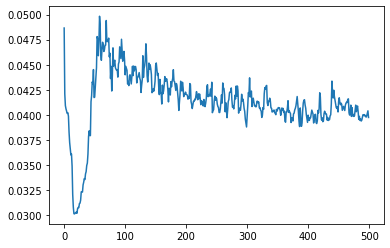

In [5]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(500):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## batch_size=512 & timesize_for_calc_correlation=50
## time_size=16 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10 &epoch=1000

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  9.886682450771332
evalution_cost :  2.8810092080384493
epoch : 0, t_cost : 0.091543, e_cost : 0.062631, elapsed time : 31.83sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.948893362656236
evalution_cost :  2.1571057215332985
epoch : 1, t_cost : 0.045823, e_cost : 0.046894, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.520289544016123
evalution_cost :  1.9376369509845972
epoch 

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.5330251920968294
evalution_cost :  1.4909392073750496
epoch : 25, t_cost : 0.023454, e_cost : 0.032412, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.4366582753136754
evalution_cost :  1.5083613321185112
epoch : 26, t_cost : 0.022562, e_cost : 0.032790, elapsed time : 26.76sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.2945660818368196
evalution_cost :  1.547936962917447
epoch : 27, t_cost : 0.021246, e_cost : 0.033651, elapsed time : 26.71sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10,

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.8283034332562238
evalution_cost :  2.0036723036319017
epoch : 51, t_cost : 0.007669, e_cost : 0.043558, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.781840555369854
evalution_cost :  2.080907529219985
epoch : 52, t_cost : 0.007239, e_cost : 0.045237, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.7447553891688585
evalution_cost :  2.1414642985910177
epoch : 53, t_cost : 0.006896, e_cost : 0.046554, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3618258471833542
evalution_cost :  2.0301413722336292
epoch : 77, t_cost : 0.003350, e_cost : 0.044134, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3764432673342526
evalution_cost :  2.027756979689002
epoch : 78, t_cost : 0.003486, e_cost : 0.044082, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3469485498499125
evalution_cost :  2.16433509811759
epoch : 79, t_cost : 0.003212, e_cost : 0.047051, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 1

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.33661637257318944
evalution_cost :  2.0722857508808374
epoch : 103, t_cost : 0.003117, e_cost : 0.045050, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3160950429737568
evalution_cost :  2.0224689785391092
epoch : 104, t_cost : 0.002927, e_cost : 0.043967, elapsed time : 26.81sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.27463204495143145
evalution_cost :  1.9990766644477844
epoch : 105, t_cost : 0.002543, e_cost : 0.043458, elapsed time : 26.79sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.27941256284248084
evalution_cost :  1.9085311572998762
epoch : 129, t_cost : 0.002587, e_cost : 0.041490, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.25596888992004097
evalution_cost :  1.8973861932754517
epoch : 130, t_cost : 0.002370, e_cost : 0.041248, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.2200191750016529
evalution_cost :  1.9448371920734644
epoch : 131, t_cost : 0.002037, e_cost : 0.042279, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.16033883532509208
evalution_cost :  1.8433284778147936
epoch : 155, t_cost : 0.001485, e_cost : 0.040072, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1758006655727513
evalution_cost :  1.8630098700523376
epoch : 156, t_cost : 0.001628, e_cost : 0.040500, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.17969103902578354
evalution_cost :  1.8511198665946722
epoch : 157, t_cost : 0.001664, e_cost : 0.040242, elapsed time : 26.52sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1761978031718172
evalution_cost :  1.9090223722159863
epoch : 181, t_cost : 0.001631, e_cost : 0.041500, elapsed time : 26.52sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.17136342491721734
evalution_cost :  1.8583022076636553
epoch : 182, t_cost : 0.001587, e_cost : 0.040398, elapsed time : 26.77sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.15308904540142976
evalution_cost :  1.8808317761868238
epoch : 183, t_cost : 0.001417, e_cost : 0.040888, elapsed time : 26.80sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.14947729799314402
evalution_cost :  1.9170752223581076
epoch : 207, t_cost : 0.001384, e_cost : 0.041676, elapsed time : 26.76sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.17028183169895783
evalution_cost :  1.931954139843583
epoch : 208, t_cost : 0.001577, e_cost : 0.041999, elapsed time : 26.54sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1887342192349024
evalution_cost :  1.895758843049407
epoch : 209, t_cost : 0.001748, e_cost : 0.041212, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895,

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.10061986838991288
evalution_cost :  1.8554012570530176
epoch : 233, t_cost : 0.000932, e_cost : 0.040335, elapsed time : 26.44sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09745860158000141
evalution_cost :  1.8574885055422783
epoch : 234, t_cost : 0.000902, e_cost : 0.040380, elapsed time : 26.52sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.10226723516825587
evalution_cost :  1.8781890831887722
epoch : 235, t_cost : 0.000947, e_cost : 0.040830, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09226086082344409
evalution_cost :  1.924378752708435
epoch : 259, t_cost : 0.000854, e_cost : 0.041834, elapsed time : 26.63sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09323498062440194
evalution_cost :  1.9338381979614496
epoch : 260, t_cost : 0.000863, e_cost : 0.042040, elapsed time : 26.87sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09508569150057156
evalution_cost :  1.9192378725856543
epoch : 261, t_cost : 0.000880, e_cost : 0.041723, elapsed time : 27.02sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08639771032903809
evalution_cost :  1.9315613973885775
epoch : 285, t_cost : 0.000800, e_cost : 0.041990, elapsed time : 26.86sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08768901793519035
evalution_cost :  1.9272957555949688
epoch : 286, t_cost : 0.000812, e_cost : 0.041898, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08678248718206305
evalution_cost :  1.9088707081973553
epoch : 287, t_cost : 0.000804, e_cost : 0.041497, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08727877639466897
evalution_cost :  1.9049396347254515
epoch : 311, t_cost : 0.000808, e_cost : 0.041412, elapsed time : 26.49sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08336763552506454
evalution_cost :  1.8585320673882961
epoch : 312, t_cost : 0.000772, e_cost : 0.040403, elapsed time : 26.35sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08565623502363451
evalution_cost :  1.8229533731937408
epoch : 313, t_cost : 0.000793, e_cost : 0.039629, elapsed time : 26.44sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07291169904056005
evalution_cost :  1.8573163822293282
epoch : 337, t_cost : 0.000675, e_cost : 0.040376, elapsed time : 26.41sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.07669491322303656
evalution_cost :  1.8250910695642233
epoch : 338, t_cost : 0.000710, e_cost : 0.039676, elapsed time : 26.31sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08074726261838805
evalution_cost :  1.8465803004801273
epoch : 339, t_cost : 0.000748, e_cost : 0.040143, elapsed time : 26.33sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08624987141229212
evalution_cost :  1.8602723125368357
epoch : 363, t_cost : 0.000799, e_cost : 0.040441, elapsed time : 26.71sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.10970716521842405
evalution_cost :  1.900964131578803
epoch : 364, t_cost : 0.001016, e_cost : 0.041325, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.1743902588787023
evalution_cost :  1.9556821528822184
epoch : 365, t_cost : 0.001615, e_cost : 0.042515, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.10175162012455985
evalution_cost :  1.8607778958976269
epoch : 389, t_cost : 0.000942, e_cost : 0.040452, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.11022100417176262
evalution_cost :  1.8920244816690683
epoch : 390, t_cost : 0.001021, e_cost : 0.041131, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.09625723701901734
evalution_cost :  1.9574904702603817
epoch : 391, t_cost : 0.000891, e_cost : 0.042554, elapsed time : 26.54sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05021930969087407
evalution_cost :  1.8873141948133707
epoch : 415, t_cost : 0.000465, e_cost : 0.041029, elapsed time : 26.66sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04885875276522711
evalution_cost :  1.8869062419980764
epoch : 416, t_cost : 0.000452, e_cost : 0.041020, elapsed time : 26.95sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04740646573191043
evalution_cost :  1.9130047522485256
epoch : 417, t_cost : 0.000439, e_cost : 0.041587, elapsed time : 27.03sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05950814444804564
evalution_cost :  1.9046472366899252
epoch : 441, t_cost : 0.000551, e_cost : 0.041405, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05356236932857428
evalution_cost :  1.8998026233166456
epoch : 442, t_cost : 0.000496, e_cost : 0.041300, elapsed time : 26.58sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.048943244968540967
evalution_cost :  1.9095389507710934
epoch : 443, t_cost : 0.000453, e_cost : 0.041512, elapsed time : 26.61sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.08387917937943712
evalution_cost :  1.7940708920359612
epoch : 467, t_cost : 0.000777, e_cost : 0.039002, elapsed time : 26.55sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06656766004743986
evalution_cost :  1.839636966586113
epoch : 468, t_cost : 0.000616, e_cost : 0.039992, elapsed time : 26.62sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06048466986976564
evalution_cost :  1.8522254042327404
epoch : 469, t_cost : 0.000560, e_cost : 0.040266, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05984153496683575
evalution_cost :  1.91416204161942
epoch : 493, t_cost : 0.000554, e_cost : 0.041612, elapsed time : 26.78sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05544335414015222
evalution_cost :  1.9115212485194206
epoch : 494, t_cost : 0.000513, e_cost : 0.041555, elapsed time : 26.98sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04999056374072097
evalution_cost :  1.9217050857841969
epoch : 495, t_cost : 0.000463, e_cost : 0.041776, elapsed time : 26.98sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.041156020990456454
evalution_cost :  1.9180477559566498
epoch : 519, t_cost : 0.000381, e_cost : 0.041697, elapsed time : 26.83sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.040237606670416426
evalution_cost :  1.920857273042202
epoch : 520, t_cost : 0.000373, e_cost : 0.041758, elapsed time : 26.62sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.039649703132454306
evalution_cost :  1.9064482897520065
epoch : 521, t_cost : 0.000367, e_cost : 0.041445, elapsed time : 26.59sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.037816318494151346
evalution_cost :  1.9010917693376541
epoch : 545, t_cost : 0.000350, e_cost : 0.041328, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03804930886690272
evalution_cost :  1.898383792489767
epoch : 546, t_cost : 0.000352, e_cost : 0.041269, elapsed time : 26.51sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.037837405732716434
evalution_cost :  1.892688263207674
epoch : 547, t_cost : 0.000350, e_cost : 0.041145, elapsed time : 26.57sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.047854214964900166
evalution_cost :  1.842847466468811
epoch : 571, t_cost : 0.000443, e_cost : 0.040062, elapsed time : 26.80sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0486009503074456
evalution_cost :  1.8396292440593243
epoch : 572, t_cost : 0.000450, e_cost : 0.039992, elapsed time : 27.05sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04917957668658346
evalution_cost :  1.8370228204876184
epoch : 573, t_cost : 0.000455, e_cost : 0.039935, elapsed time : 26.97sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05667164450278506
evalution_cost :  1.9341780841350555
epoch : 597, t_cost : 0.000525, e_cost : 0.042047, elapsed time : 26.64sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.050546709302579984
evalution_cost :  1.9268372152000666
epoch : 598, t_cost : 0.000468, e_cost : 0.041888, elapsed time : 26.50sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.048770842142403126
evalution_cost :  1.9037196338176727
epoch : 599, t_cost : 0.000452, e_cost : 0.041385, elapsed time : 26.54sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2

traning_cost :  0.03578371295589022
evalution_cost :  1.8557586651295424
epoch : 622, t_cost : 0.000331, e_cost : 0.040343, elapsed time : 26.70sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03524399202433415
evalution_cost :  1.852315915748477
epoch : 623, t_cost : 0.000326, e_cost : 0.040268, elapsed time : 26.60sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.034807012241799384
evalution_cost :  1.8610356003046036
epoch : 624, t_cost : 0.000322, e_cost : 0.040457, elapsed time : 26.56sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0347559438

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03744095085130539
evalution_cost :  1.8017477598041296
epoch : 648, t_cost : 0.000347, e_cost : 0.039168, elapsed time : 26.53sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0368925807197229
evalution_cost :  1.8126816507428885
epoch : 649, t_cost : 0.000342, e_cost : 0.039406, elapsed time : 26.79sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03697657303564483
evalution_cost :  1.8167312797158957
epoch : 650, t_cost : 0.000342, e_cost : 0.039494, elapsed time : 26.99sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03453247923607705
evalution_cost :  1.8738012667745352
epoch : 674, t_cost : 0.000320, e_cost : 0.040735, elapsed time : 26.65sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.034739748647552915
evalution_cost :  1.870238596573472
epoch : 675, t_cost : 0.000322, e_cost : 0.040657, elapsed time : 26.52sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.035403382702497765
evalution_cost :  1.881404997780919
epoch : 676, t_cost : 0.000328, e_cost : 0.040900, elapsed time : 26.31sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.050019306247122586
evalution_cost :  1.827568793669343
epoch : 700, t_cost : 0.000463, e_cost : 0.039730, elapsed time : 27.16sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.044107397319749
evalution_cost :  1.826318709179759
epoch : 701, t_cost : 0.000408, e_cost : 0.039703, elapsed time : 27.19sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04013274789031129
evalution_cost :  1.845588095486164
epoch : 702, t_cost : 0.000372, e_cost : 0.040121, elapsed time : 26.91sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.060983426723396406
evalution_cost :  1.781933544203639
epoch : 726, t_cost : 0.000565, e_cost : 0.038738, elapsed time : 26.21sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05730665332521312
evalution_cost :  1.7780052442103624
epoch : 727, t_cost : 0.000531, e_cost : 0.038652, elapsed time : 26.35sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05432480997114908
evalution_cost :  1.834969099611044
epoch : 728, t_cost : 0.000503, e_cost : 0.039891, elapsed time : 26.46sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (2389

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05233175303146709
evalution_cost :  1.8260832410305738
epoch : 752, t_cost : 0.000485, e_cost : 0.039697, elapsed time : 26.41sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.06201996385061648
evalution_cost :  1.8322765324264765
epoch : 753, t_cost : 0.000574, e_cost : 0.039832, elapsed time : 26.43sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.057170388390659355
evalution_cost :  1.8519637044519186
epoch : 754, t_cost : 0.000529, e_cost : 0.040260, elapsed time : 26.42sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04835748524055816
evalution_cost :  1.805478323251009
epoch : 778, t_cost : 0.000448, e_cost : 0.039250, elapsed time : 26.37sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.0517869003379019
evalution_cost :  1.7968686930835247
epoch : 779, t_cost : 0.000480, e_cost : 0.039062, elapsed time : 26.41sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05245735299831722
evalution_cost :  1.8478152230381966
epoch : 780, t_cost : 0.000486, e_cost : 0.040170, elapsed time : 26.43sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895

data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03555330724339001
evalution_cost :  1.8641097731888294
epoch : 804, t_cost : 0.000329, e_cost : 0.040524, elapsed time : 30.82sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03658752998308046
evalution_cost :  1.8671651892364025
epoch : 805, t_cost : 0.000339, e_cost : 0.040591, elapsed time : 30.83sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.038255224892054684
evalution_cost :  1.8634058088064194
epoch : 806, t_cost : 0.000354, e_cost : 0.040509, elapsed time : 30.87sec
data1 :  (55755, 16, 1) (55

traning_cost :  0.11837279325118288
evalution_cost :  1.9102967455983162
epoch : 829, t_cost : 0.001096, e_cost : 0.041528, elapsed time : 31.06sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.14512574108084664
evalution_cost :  1.8493362497538328
epoch : 830, t_cost : 0.001344, e_cost : 0.040203, elapsed time : 31.16sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.10301118969800882
evalution_cost :  1.813638525083661
epoch : 831, t_cost : 0.000954, e_cost : 0.039427, elapsed time : 31.29sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05660091066

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05169360197032802
evalution_cost :  1.8193003870546818
epoch : 855, t_cost : 0.000479, e_cost : 0.039550, elapsed time : 31.11sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.05133689846843481
evalution_cost :  1.8738745916634798
epoch : 856, t_cost : 0.000475, e_cost : 0.040736, elapsed time : 31.14sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.04721404062001966
evalution_cost :  1.8406678028404713
epoch : 857, t_cost : 0.000437, e_cost : 0.040015, elapsed time : 31.04sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (238

data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03104378979332978
evalution_cost :  1.7867180369794369
epoch : 881, t_cost : 0.000287, e_cost : 0.038842, elapsed time : 31.46sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.031205811334075406
evalution_cost :  1.7809635419398546
epoch : 882, t_cost : 0.000289, e_cost : 0.038717, elapsed time : 31.27sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03127439923991915
evalution_cost :  1.7663701847195625
epoch : 883, t_cost : 0.000290, e_cost : 0.038399, elapsed time : 30.47sec
data1 :  (55755, 16, 1) (55

traning_cost :  0.031709171198599506
evalution_cost :  1.874987993389368
epoch : 906, t_cost : 0.000294, e_cost : 0.040761, elapsed time : 32.23sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.031837470683967695
evalution_cost :  1.8655190225690603
epoch : 907, t_cost : 0.000295, e_cost : 0.040555, elapsed time : 31.97sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.032940446988504846
evalution_cost :  1.859372403472662
epoch : 908, t_cost : 0.000305, e_cost : 0.040421, elapsed time : 32.02sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.033519017

data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.029642810644872952
evalution_cost :  1.818480722606182
epoch : 932, t_cost : 0.000274, e_cost : 0.039532, elapsed time : 31.64sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.029587042714410927
evalution_cost :  1.8185640405863523
epoch : 933, t_cost : 0.000274, e_cost : 0.039534, elapsed time : 31.83sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.029293895422597416
evalution_cost :  1.8267545830458403
epoch : 934, t_cost : 0.000271, e_cost : 0.039712, elapsed time : 32.11sec
data1 :  (55755, 16, 1) (5

traning_cost :  0.035456802404951304
evalution_cost :  1.7577322665601969
epoch : 957, t_cost : 0.000328, e_cost : 0.038212, elapsed time : 32.62sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03577687083452474
evalution_cost :  1.7559707537293434
epoch : 958, t_cost : 0.000331, e_cost : 0.038173, elapsed time : 32.26sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.035885348755982704
evalution_cost :  1.7899558786302805
epoch : 959, t_cost : 0.000332, e_cost : 0.038912, elapsed time : 32.08sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.03730515

data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.029846097058907617
evalution_cost :  1.7717254664748907
epoch : 983, t_cost : 0.000276, e_cost : 0.038516, elapsed time : 31.48sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.029939229352748953
evalution_cost :  1.78098170645535
epoch : 984, t_cost : 0.000277, e_cost : 0.038717, elapsed time : 31.42sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.031041693371662404
evalution_cost :  1.7772481609135866
epoch : 985, t_cost : 0.000287, e_cost : 0.038636, elapsed time : 30.34sec
data1 :  (55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23

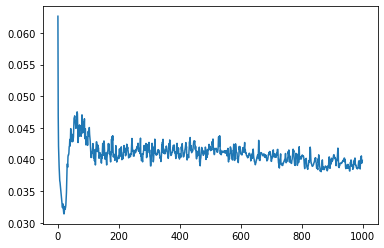

In [6]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(1000):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [8]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,4,self.T,1))
        xn=np.reshape(xn,(-1,4,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(4,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(4,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  7.709406467154622
evalution_cost :  2.1631529983133078
epoch : 0, t_cost : 0.071383, e_cost : 0.047025, elapsed time : 23.85sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.488579645752907
evalution_cost :  1.8513044156134129
epoch : 1, t_cost : 0.041561, e_cost : 0.040246, elapsed time : 20.13sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.121639467775822
evalution_cost :  1.738362142816186
epoch : 2, t_cost :

traning_cost :  2.927298853173852
evalution_cost :  1.329957403242588
epoch : 25, t_cost : 0.027105, e_cost : 0.028912, elapsed time : 19.21sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.8908673394471407
evalution_cost :  1.361226199194789
epoch : 26, t_cost : 0.026767, e_cost : 0.029592, elapsed time : 19.11sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.893092755228281
evalution_cost :  1.3384488802403212
epoch : 27, t_cost : 0.026788, e_cost : 0.029097, elapsed time : 19.05sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.8732459852471948
evalution_cost 

traning_cost :  1.6943950378336012
evalution_cost :  1.7156303152441978
epoch : 51, t_cost : 0.015689, e_cost : 0.037296, elapsed time : 18.72sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.7011199067346752
evalution_cost :  1.7559338454157114
epoch : 52, t_cost : 0.015751, e_cost : 0.038172, elapsed time : 18.80sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.5166180930100381
evalution_cost :  1.7077740598469973
epoch : 53, t_cost : 0.014043, e_cost : 0.037126, elapsed time : 18.80sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  1.3161472133360803
evalution_c

traning_cost :  0.4142846576869488
evalution_cost :  2.073526233434677
epoch : 77, t_cost : 0.003836, e_cost : 0.045077, elapsed time : 19.09sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.41938083863351494
evalution_cost :  2.0748612135648727
epoch : 78, t_cost : 0.003883, e_cost : 0.045106, elapsed time : 18.90sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.4028277222532779
evalution_cost :  1.9832936506718397
epoch : 79, t_cost : 0.003730, e_cost : 0.043115, elapsed time : 18.92sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.41892493120394647
evalution_

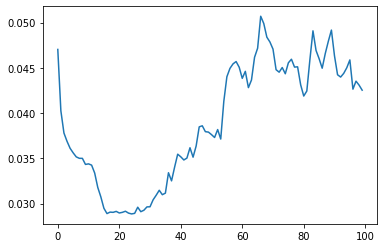

In [9]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  8.249754950404167
evalution_cost :  1.937768081203103
epoch : 0, t_cost : 0.076387, e_cost : 0.042125, elapsed time : 8.61sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  4.087453639134765
evalution_cost :  1.8830631710588932
epoch : 1, t_cost : 0.037847, e_cost : 0.040936, elapsed time : 5.32sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.9539468567818403
evalution_cost :  1.8062281236052513
epoch : 2, t_cost : 0.036611, e_cost : 0.039

data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.3209444638341665
evalution_cost :  1.457105990499258
epoch : 26, t_cost : 0.030749, e_cost : 0.031676, elapsed time : 5.30sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.305941805243492
evalution_cost :  1.462274856865406
epoch : 27, t_cost : 0.030611, e_cost : 0.031789, elapsed time : 5.29sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.29080400057137
evalution_cost :  1.4623482022434473
epoch : 28, t_cost : 0.030470, e_cost : 0.031790, elapsed time : 5.33sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895,

data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.980681663379073
evalution_cost :  1.4425746276974678
epoch : 53, t_cost : 0.027599, e_cost : 0.031360, elapsed time : 5.21sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.983380534686148
evalution_cost :  1.4452311880886555
epoch : 54, t_cost : 0.027624, e_cost : 0.031418, elapsed time : 5.24sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.965740860439837
evalution_cost :  1.4471073877066374
epoch : 55, t_cost : 0.027461, e_cost : 0.031459, elapsed time : 5.24sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (2389

data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.447065658867359
evalution_cost :  1.5913651417940855
epoch : 80, t_cost : 0.022658, e_cost : 0.034595, elapsed time : 5.27sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.421148583292961
evalution_cost :  1.6387021020054817
epoch : 81, t_cost : 0.022418, e_cost : 0.035624, elapsed time : 5.26sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  2.430577890947461
evalution_cost :  1.6296038068830967
epoch : 82, t_cost : 0.022505, e_cost : 0.035426, elapsed time : 5.28sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (2389

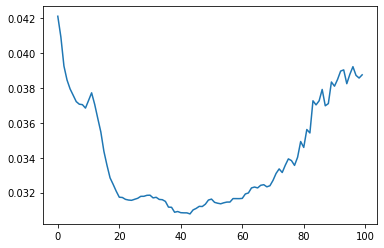

In [10]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  12.90670844912529
evalution_cost :  3.8908285293728113
epoch : 0, t_cost : 0.059478, e_cost : 0.041837, elapsed time : 9.23sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  8.040878228843212
evalution_cost :  3.7403250094503164
epoch : 1, t_cost : 0.037055, e_cost : 0.040219, elapsed time : 6.22sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  7.884565394371748
evalution_cost :  3.5765661718323827
epoch : 2, t_cost : 0.036334, e_cost : 0.038

traning_cost :  6.188758973963559
evalution_cost :  2.8887435300275683
epoch : 26, t_cost : 0.028520, e_cost : 0.031062, elapsed time : 6.27sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  6.163770993240178
evalution_cost :  2.9040745748206973
epoch : 27, t_cost : 0.028404, e_cost : 0.031227, elapsed time : 6.18sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  6.137138523161411
evalution_cost :  2.930856814607978
epoch : 28, t_cost : 0.028282, e_cost : 0.031515, elapsed time : 6.24sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  6.094350900501013
evalution_cost :  2.9141646632924676
epoch 

data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  5.1333912294358015
evalution_cost :  3.277829193510115
epoch : 53, t_cost : 0.023656, e_cost : 0.035245, elapsed time : 5.98sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  5.0806169752031565
evalution_cost :  3.443113054148853
epoch : 54, t_cost : 0.023413, e_cost : 0.037023, elapsed time : 6.13sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  4.9232623325660825
evalution_cost :  3.3751270435750484
epoch : 55, t_cost : 0.022688, e_cost : 0.036292, elapsed time : 6.08sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (238

data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.387483381666243
evalution_cost :  4.186747002415359
epoch : 80, t_cost : 0.015611, e_cost : 0.045019, elapsed time : 6.19sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.493935805046931
evalution_cost :  4.246705983765423
epoch : 81, t_cost : 0.016101, e_cost : 0.045664, elapsed time : 6.24sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)
traning_cost :  3.4816513301339
evalution_cost :  4.278363969642669
epoch : 82, t_cost : 0.016044, e_cost : 0.046004, elapsed time : 5.75sec
data1 :  (55755, 4, 1) (55755, 4, 4, 1) (55755, 4, 4, 1) (55755, 4, 1) (55755, 1)
data1 :  (23895, 4, 1) (23895, 4, 4, 1) (23895, 4, 4, 1) (23895, 4, 1) (23895, 1)

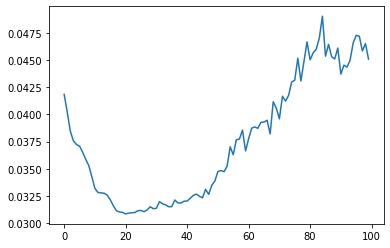

In [11]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  9.498758563771844
evalution_cost :  1.9734884537756443
epoch : 0, t_cost : 0.087951, e_cost : 0.042902, elapsed time : 8.44sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  4.088354155421257
evalution_cost :  1.8752389196306467
epoch : 1, t_cost : 0.037855, e_cost : 0.040766, elapsed time : 5.29sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  3.96827756986022
evalution_cost :  1.830683371052146
epoch : 2, t_cost : 0.036743, e_cost : 0.03979

traning_cost :  3.2677589878439903
evalution_cost :  1.442635178565979
epoch : 26, t_cost : 0.030257, e_cost : 0.031362, elapsed time : 5.25sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  3.2553344536572695
evalution_cost :  1.4443382285535336
epoch : 27, t_cost : 0.030142, e_cost : 0.031399, elapsed time : 5.22sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  3.235789805650711
evalution_cost :  1.4498540218919516
epoch : 28, t_cost : 0.029961, e_cost : 0.031519, elapsed time : 5.26sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  3.222841439768672
evalution_cost :  1.4466313850134611
epoc

data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.9400713266804814
evalution_cost :  1.458110000938177
epoch : 53, t_cost : 0.027223, e_cost : 0.031698, elapsed time : 5.31sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.924414176493883
evalution_cost :  1.4396189488470554
epoch : 54, t_cost : 0.027078, e_cost : 0.031296, elapsed time : 5.41sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.9177242424339056
evalution_cost :  1.4405932109802961
epoch : 55, t_cost : 0.027016, e_cost : 0.031317, elapsed time : 5.33sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (237

data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.4203631803393364
evalution_cost :  1.5673746187239885
epoch : 80, t_cost : 0.022411, e_cost : 0.034073, elapsed time : 5.29sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.3909472497180104
evalution_cost :  1.543715862557292
epoch : 81, t_cost : 0.022138, e_cost : 0.033559, elapsed time : 5.24sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (23733, 1)
traning_cost :  2.361308434046805
evalution_cost :  1.5723878424614668
epoch : 82, t_cost : 0.021864, e_cost : 0.034182, elapsed time : 5.26sec
data1 :  (55377, 4, 1) (55377, 4, 4, 1) (55377, 4, 4, 1) (55377, 4, 1) (55377, 1)
data1 :  (23733, 4, 1) (23733, 4, 4, 1) (23733, 4, 4, 1) (23733, 4, 1) (237

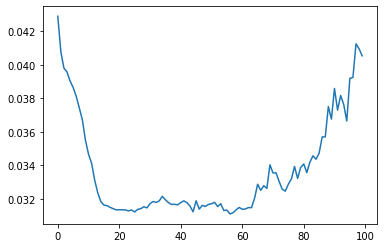

In [12]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  9.417142823338509
evalution_cost :  2.352102503180504
epoch : 0, t_cost : 0.087196, e_cost : 0.051133, elapsed time : 22.00sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.7289039101451635
evalution_cost :  1.8577400334179401
epoch : 1, t_cost : 0.043786, e_cost : 0.040386, elapsed time : 18.78sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  4.170701798051596
evalution_cost :  1.7234385404735804
epoch : 2, t_cost 

traning_cost :  2.6336097763851285
evalution_cost :  1.5611108653247356
epoch : 25, t_cost : 0.024385, e_cost : 0.033937, elapsed time : 19.13sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.6678545381873846
evalution_cost :  1.469567621126771
epoch : 26, t_cost : 0.024702, e_cost : 0.031947, elapsed time : 18.92sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.5334560684859753
evalution_cost :  1.4901046883314848
epoch : 27, t_cost : 0.023458, e_cost : 0.032394, elapsed time : 18.88sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  2.4310138626024127
evalution_co

traning_cost :  0.8407837816048414
evalution_cost :  2.2701585981994867
epoch : 51, t_cost : 0.007785, e_cost : 0.049351, elapsed time : 18.95sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.7844547969289124
evalution_cost :  2.2214314937591553
epoch : 52, t_cost : 0.007263, e_cost : 0.048292, elapsed time : 19.16sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.7560568668413907
evalution_cost :  2.2986493799835443
epoch : 53, t_cost : 0.007001, e_cost : 0.049971, elapsed time : 19.00sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.7327687246724963
evalution_c

traning_cost :  0.43015930091496557
evalution_cost :  2.2526882737874985
epoch : 77, t_cost : 0.003983, e_cost : 0.048971, elapsed time : 18.78sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.406570510705933
evalution_cost :  2.261783244088292
epoch : 78, t_cost : 0.003765, e_cost : 0.049169, elapsed time : 18.44sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3961377162486315
evalution_cost :  2.1891881320625544
epoch : 79, t_cost : 0.003668, e_cost : 0.047591, elapsed time : 18.39sec
data1 :  (55755, 16, 1) (55755, 4, 16, 1) (55755, 4, 16, 1) (55755, 16, 1) (55755, 1)
data1 :  (23895, 16, 1) (23895, 4, 16, 1) (23895, 4, 16, 1) (23895, 16, 1) (23895, 1)
traning_cost :  0.3885597609914839
evalution_co

data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.945630945265293
evalution_cost :  1.7227437477558851
epoch : 3, t_cost : 0.036534, e_cost : 0.037451, elapsed time : 9.71sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.8303127735853195
evalution_cost :  1.6839014887809753
epoch : 4, t_cost : 0.035466, e_cost : 0.036607, elapsed time : 9.82sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.6925520822405815
evalution_cost :  1.6659791748970747
epoch : 5, t_cost : 0.034190, e_cost : 0.036217, elapsed time : 9.80sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733

data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.058386217802763
evalution_cost :  1.477796884253621
epoch : 30, t_cost : 0.028318, e_cost : 0.032126, elapsed time : 9.88sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.0253993291407824
evalution_cost :  1.4703138060867786
epoch : 31, t_cost : 0.028013, e_cost : 0.031963, elapsed time : 9.83sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  3.007544162683189
evalution_cost :  1.4749166052788496
epoch : 32, t_cost : 0.027848, e_cost : 0.032063, elapsed time : 9.80sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (2373

data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  1.9966684058308601
evalution_cost :  1.9216438308358192
epoch : 57, t_cost : 0.018488, e_cost : 0.041775, elapsed time : 9.90sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  1.8390123462304473
evalution_cost :  1.9624173920601606
epoch : 58, t_cost : 0.017028, e_cost : 0.042661, elapsed time : 9.86sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  1.7130640451796353
evalution_cost :  1.9919082708656788
epoch : 59, t_cost : 0.015862, e_cost : 0.043302, elapsed time : 9.89sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (2

data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  0.7814973862841725
evalution_cost :  2.4467897824943066
epoch : 84, t_cost : 0.007236, e_cost : 0.053191, elapsed time : 9.87sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  0.7186468646395952
evalution_cost :  2.332536270841956
epoch : 85, t_cost : 0.006654, e_cost : 0.050707, elapsed time : 9.89sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (23733, 1)
traning_cost :  0.7462536334060133
evalution_cost :  2.369579777121544
epoch : 86, t_cost : 0.006910, e_cost : 0.051513, elapsed time : 9.91sec
data1 :  (55377, 8, 1) (55377, 4, 8, 1) (55377, 4, 8, 1) (55377, 8, 1) (55377, 1)
data1 :  (23733, 8, 1) (23733, 4, 8, 1) (23733, 4, 8, 1) (23733, 8, 1) (237

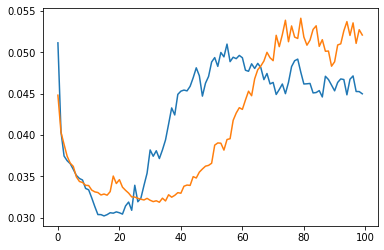

In [13]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  12.48372439108789
evalution_cost :  3.726091300137341
epoch : 0, t_cost : 0.058335, e_cost : 0.040946, elapsed time : 9.34sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  7.9880662728101015
evalution_cost :  3.524514210410416
epoch : 1, t_cost : 0.037327, e_cost : 0.038731, elapsed time : 6.15sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  7.767376242205501
evalution_cost :  3.4394748639315367
epoch : 2, t_cost : 0.036296, e_cost : 0.0377

traning_cost :  6.2034148862585425
evalution_cost :  2.8538187062367797
epoch : 26, t_cost : 0.028988, e_cost : 0.031361, elapsed time : 6.18sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  6.179604538716376
evalution_cost :  2.856790046207607
epoch : 27, t_cost : 0.028877, e_cost : 0.031393, elapsed time : 6.21sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  6.150597430765629
evalution_cost :  2.819236815907061
epoch : 28, t_cost : 0.028741, e_cost : 0.030981, elapsed time : 6.27sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  6.115007241256535
evalution_cost :  2.847401556558907
epoch :

data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  4.880457967054099
evalution_cost :  3.4123315680772066
epoch : 53, t_cost : 0.022806, e_cost : 0.037498, elapsed time : 6.13sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  4.945039762649685
evalution_cost :  3.2618551570922136
epoch : 54, t_cost : 0.023108, e_cost : 0.035845, elapsed time : 6.22sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  4.81641751807183
evalution_cost :  3.3645207807421684
epoch : 55, t_cost : 0.022507, e_cost : 0.036973, elapsed time : 5.66sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490

data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.1463454738259315
evalution_cost :  3.5090086460113525
epoch : 80, t_cost : 0.014703, e_cost : 0.038561, elapsed time : 6.23sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.0672997306101024
evalution_cost :  3.540213108062744
epoch : 81, t_cost : 0.014333, e_cost : 0.038903, elapsed time : 6.30sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.98932445095852
evalution_cost :  3.5453131571412086
epoch : 82, t_cost : 0.013969, e_cost : 0.038959, elapsed time : 6.25sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (2349

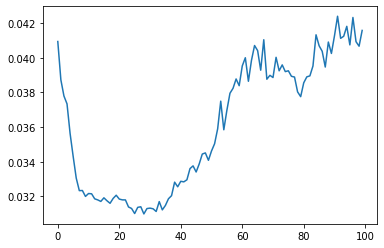

In [14]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	

#training#
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  8.581749204546213
evalution_cost :  1.9818880204111338
epoch : 0, t_cost : 0.080203, e_cost : 0.044042, elapsed time : 8.61sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  4.0747569017112255
evalution_cost :  1.8371231444180012
epoch : 1, t_cost : 0.038082, e_cost : 0.040825, elapsed time : 5.19sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.9140221439301968
evalution_cost :  1.7617197819054127
epoch : 2, t_cost : 0.036580, e_cost : 0.0

data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.2100153602659702
evalution_cost :  1.4228276945650578
epoch : 26, t_cost : 0.030000, e_cost : 0.031618, elapsed time : 5.28sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.2013500183820724
evalution_cost :  1.41209208779037
epoch : 27, t_cost : 0.029919, e_cost : 0.031380, elapsed time : 5.27sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  3.188599392771721
evalution_cost :  1.4072228353470564
epoch : 28, t_cost : 0.029800, e_cost : 0.031272, elapsed time : 5.23sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (2349

data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.858393669128418
evalution_cost :  1.4510890953242779
epoch : 53, t_cost : 0.026714, e_cost : 0.032246, elapsed time : 5.37sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.84660738799721
evalution_cost :  1.4439346808940172
epoch : 54, t_cost : 0.026604, e_cost : 0.032087, elapsed time : 5.36sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.818293349817395
evalution_cost :  1.4442316684871912
epoch : 55, t_cost : 0.026339, e_cost : 0.032094, elapsed time : 5.34sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490

data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.110280066728592
evalution_cost :  1.840310925617814
epoch : 80, t_cost : 0.019722, e_cost : 0.040896, elapsed time : 5.28sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.0834804540500045
evalution_cost :  1.901733921840787
epoch : 81, t_cost : 0.019472, e_cost : 0.042261, elapsed time : 5.28sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490, 1)
traning_cost :  2.015512954443693
evalution_cost :  1.8863156884908676
epoch : 82, t_cost : 0.018837, e_cost : 0.041918, elapsed time : 5.27sec
data1 :  (54810, 4, 1) (54810, 4, 4, 1) (54810, 4, 4, 1) (54810, 4, 1) (54810, 1)
data1 :  (23490, 4, 1) (23490, 4, 4, 1) (23490, 4, 4, 1) (23490, 4, 1) (23490

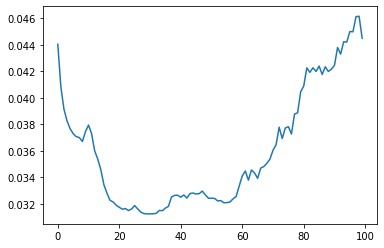

In [15]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [16]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=10000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677,

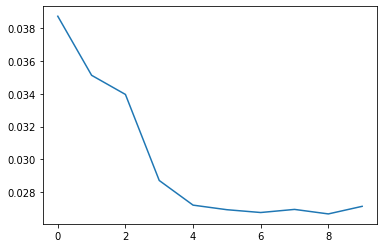

In [8]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  33.68811442423612
evalution_cost :  13.830660887993872
epoch : 0, t_cost : 0.045959, e_cost : 0.044047, elapsed time : 133.86sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  24.56386166997254
evalution_cost :  12.420498139224946
epoch : 1, t_cost : 0.033511, e_cost : 0.039556, elapsed time : 126.11sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  22.320433541201055
evalution_cost :  9.07

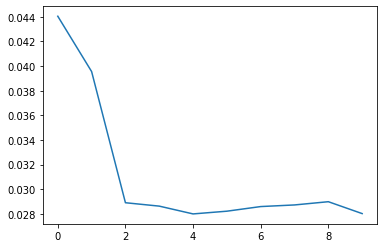

In [9]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  18.944059556350112
evalution_cost :  5.935510936193168
epoch : 0, t_cost : 0.051760, e_cost : 0.037806, elapsed time : 250.36sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  12.809878962114453
evalution_cost :  5.721974885091186
epoch : 1, t_cost : 0.035000, e_cost : 0.036446, elapsed time : 243.81sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  11.85754388384521
evalution_cost :  5.462

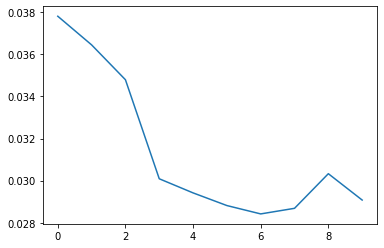

In [10]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  18.686272146180272
evalution_cost :  6.157471161335707
epoch : 0, t_cost : 0.051055, e_cost : 0.039220, elapsed time : 128.71sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  12.684271855279803
evalution_cost :  5.2972786873579025
epoch : 1, t_cost : 0.034656, e_cost : 0.033741, elapsed time : 120.00sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  11.912506157532334
evalution_cost :  5.2

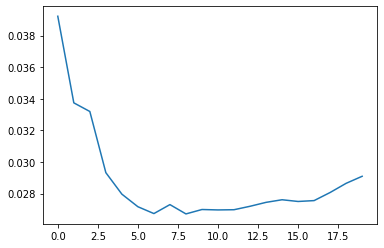

In [11]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(20):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  18.816363027319312
evalution_cost :  6.258393628522754
epoch : 0, t_cost : 0.051411, e_cost : 0.039862, elapsed time : 251.60sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  12.549230581149459
evalution_cost :  5.209371788427234
epoch : 1, t_cost : 0.034288, e_cost : 0.033181, elapsed time : 249.94sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  11.4171235980466
evalution_cost :  4.6354

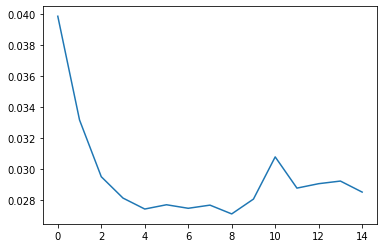

In [12]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(15):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  18.528478952124715
evalution_cost :  6.560500617139041
epoch : 0, t_cost : 0.050624, e_cost : 0.041787, elapsed time : 256.62sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  12.892420498654246
evalution_cost :  5.4578060964122415
epoch : 1, t_cost : 0.035225, e_cost : 0.034763, elapsed time : 244.27sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  11.919068178161979
evalution_cost :  5.1

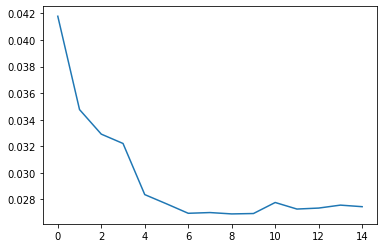

In [13]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(15):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  19.607048109173775
evalution_cost :  6.198411053046584
epoch : 0, t_cost : 0.053571, e_cost : 0.039480, elapsed time : 483.30sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  12.720996771007776
evalution_cost :  5.454010609537363
epoch : 1, t_cost : 0.034757, e_cost : 0.034739, elapsed time : 471.37sec
data1 :  (187677, 32, 1) (187677, 15, 32, 1) (187677, 15, 32, 1) (187677, 32, 1) (187677, 1)
data1 :  (80433, 32, 1) (80433, 15, 32, 1) (80433, 15, 32, 1) (80433, 32, 1) (80433, 1)
traning_cost :  11.78001931682229
evalution_cost :  6.032

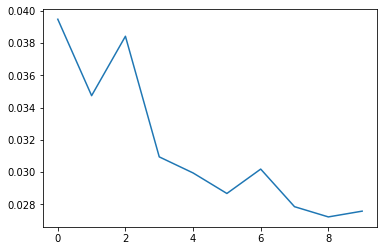

In [17]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  18.0598361492157
evalution_cost :  6.1218844801187515
epoch : 0, t_cost : 0.049344, e_cost : 0.038993, elapsed time : 249.04sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  12.699327558279037
evalution_cost :  5.545946359634399
epoch : 1, t_cost : 0.034698, e_cost : 0.035324, elapsed time : 238.14sec
data1 :  (187677, 16, 1) (187677, 15, 16, 1) (187677, 15, 16, 1) (187677, 16, 1) (187677, 1)
data1 :  (80433, 16, 1) (80433, 15, 16, 1) (80433, 15, 16, 1) (80433, 16, 1) (80433, 1)
traning_cost :  11.906283341348171
evalution_cost :  5.150

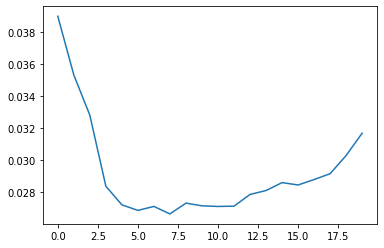

In [18]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(20):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (214488, 16, 1) (214488, 15, 16, 1) (214488, 15, 16, 1) (214488, 16, 1) (214488, 1)
data1 :  (53622, 16, 1) (53622, 15, 16, 1) (53622, 15, 16, 1) (53622, 16, 1) (53622, 1)
traning_cost :  20.920810732990503
evalution_cost :  4.36171467974782
epoch : 0, t_cost : 0.050050, e_cost : 0.041940, elapsed time : 283.32sec
data1 :  (214488, 16, 1) (214488, 15, 16, 1) (214488, 15, 16, 1) (214488, 16, 1) (214488, 1)
data1 :  (53622, 16, 1) (53622, 15, 16, 1) (53622, 15, 16, 1) (53622, 16, 1) (53622, 1)
traning_cost :  14.466348012909293
evalution_cost :  4.007023869082332
epoch : 1, t_cost : 0.034608, e_cost : 0.038529, elapsed time : 273.85sec
data1 :  (214488, 16, 1) (214488, 15, 16, 1) (214488, 15, 16, 1) (214488, 16, 1) (214488, 1)
data1 :  (53622, 16, 1) (53622, 15, 16, 1) (53622, 15, 16, 1) (53622, 16, 1) (53622, 1)
traning_cost :  13.532089551910758
evalution_cost :  3.498

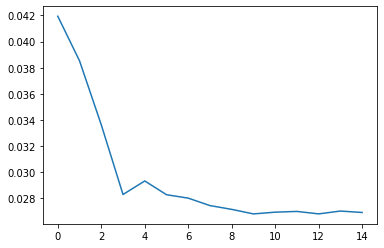

In [19]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.8
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(15):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0

#training#
data1 :  (214488, 32, 1) (214488, 15, 32, 1) (214488, 15, 32, 1) (214488, 32, 1) (214488, 1)
data1 :  (53622, 32, 1) (53622, 15, 32, 1) (53622, 15, 32, 1) (53622, 32, 1) (53622, 1)
traning_cost :  21.631354358047247
evalution_cost :  5.203779548406601
epoch : 0, t_cost : 0.051750, e_cost : 0.050036, elapsed time : 555.98sec
data1 :  (214488, 32, 1) (214488, 15, 32, 1) (214488, 15, 32, 1) (214488, 32, 1) (214488, 1)
data1 :  (53622, 32, 1) (53622, 15, 32, 1) (53622, 15, 32, 1) (53622, 32, 1) (53622, 1)
traning_cost :  14.821012865751982
evalution_cost :  3.9977757055312395
epoch : 1, t_cost : 0.035457, e_cost : 0.038440, elapsed time : 545.54sec
data1 :  (214488, 32, 1) (214488, 15, 32, 1) (214488, 15, 32, 1) (214488, 32, 1) (214488, 1)
data1 :  (53622, 32, 1) (53622, 15, 32, 1) (53622, 15, 32, 1) (53622, 32, 1) (53622, 1)
traning_cost :  13.537889261730015
evalution_cost :  3.2

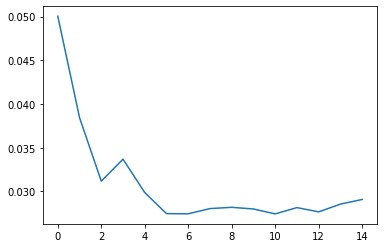

In [20]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.8
batch_size=512
#
kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(15):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))